<a href="https://colab.research.google.com/github/lee-seong-wook/ML-DL-study/blob/main/GAN_customdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

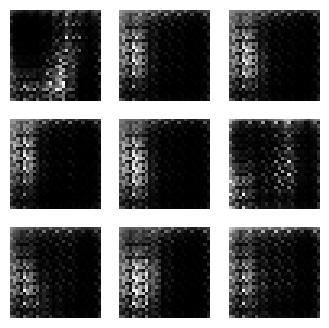

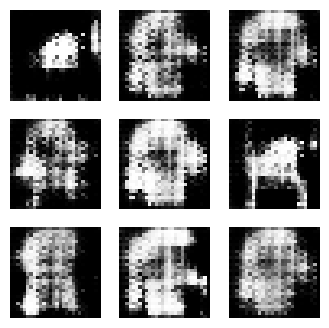

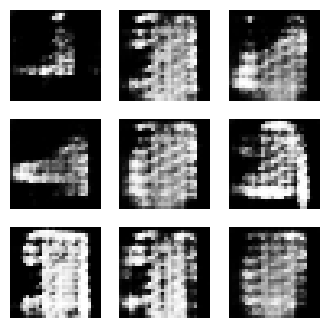

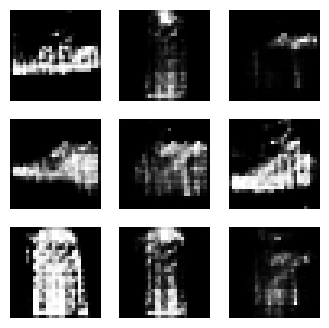

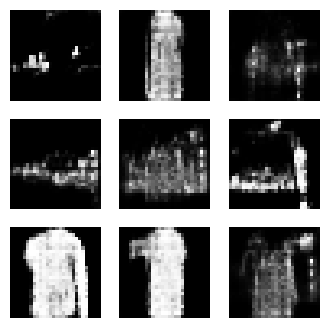

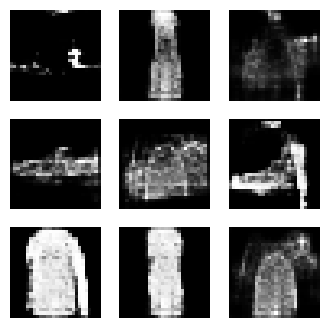

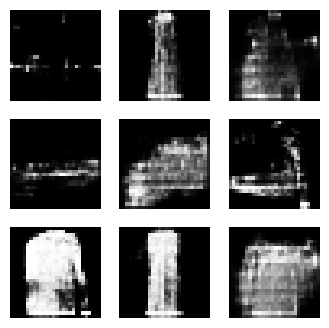

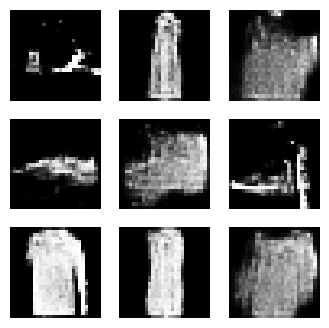

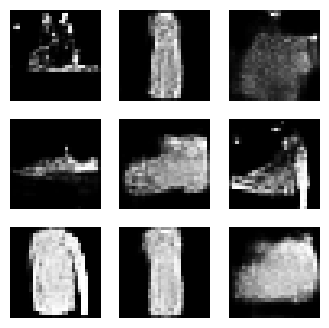

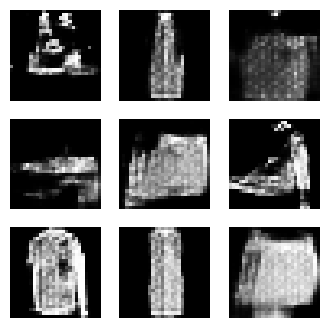

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


모델 저장 완료


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, LeakyReLU, Conv2DTranspose, Conv2D
from tensorflow.keras.models import Sequential, Model
import numpy as np
import matplotlib.pyplot as plt

# 데이터셋 로딩
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# 데이터 배치 생성
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 생성자 모델 정의
def build_generator(latent_dim):
    generator = Sequential([
        Dense(7*7*256, use_bias=False, input_shape=(latent_dim,)),
        BatchNormalization(),
        LeakyReLU(),

        Reshape((7, 7, 256)),
        Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return generator

# 판별자 모델 정의
def build_discriminator():
    discriminator = Sequential([
        Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        LeakyReLU(),
        Dropout(0.5),

        Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(),
        Dropout(0.3),

        Flatten(),
        Dense(1)
    ])
    return discriminator

# 생성자와 판별자 모델 생성
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator()

# 손실 함수 및 옵티마이저 설정
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 훈련 루프 정의
EPOCHS = 100
num_examples_to_generate = 32

seed = tf.random.normal([num_examples_to_generate, latent_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# GAN 훈련
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        if epoch % 10 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    num_examples_to_generate = min(predictions.shape[0], 9)  # 수정된 부분
    for i in range(num_examples_to_generate):
        plt.subplot(3, 3, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


# GAN 훈련 시작
train(train_dataset, EPOCHS)

# 생성자 모델 저장
generator.save('generator_model.h5')

# 판별자 모델 저장
discriminator.save('discriminator_model.h5')

print("모델 저장 완료")


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 생성된 이미지 저장된 경로와 파일명
image_path = 'generated_images/'
output_gif_path = 'gan_animation.gif'

# GAN 모델 불러오기
generator = tf.keras.models.load_model('generator_model.h5')

# 생성할 이미지 수와 latent_dim 설정
num_images = 100  # GIF에 포함할 이미지 수
latent_dim = 100  # 생성자의 입력 차원

# 생성된 이미지들을 저장할 리스트
generated_images = []

# 랜덤한 노이즈 생성 및 이미지 생성
for _ in range(num_images):
    noise = np.random.normal(0, 1, (1, latent_dim))
    gen_img = generator.predict(noise)
    gen_img = 0.5 * gen_img + 0.5  # 이미지 스케일 조정
    generated_images.append(gen_img[0])

# 생성된 이미지들로 GIF 생성
images_for_gif = [Image.fromarray((gen_img * 255).astype(np.uint8).squeeze()) for gen_img in generated_images]
images_for_gif[0].save(output_gif_path, save_all=True, append_images=images_for_gif[1:], loop=0, duration=100)

print(f'GIF 애니메이션 생성 완료: {output_gif_path}')


1/1 [==============================] - 0s 17ms/step
GIF 애니메이션 생성 완료: gan_animation.gif


In [ ]:
#https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko 참고함